## Table of contents
### - [Introduction](#Introduction)
### - [Setup](#Setup)
### - [Example image](#Example-image)
### - [Automatic mask generation](#Automatic-mask-generation)
### - [Automatic mask generation options](#Automatic-mask-generation-options)
### - [Classification model](#Classification-model)
### - [Inference](#Inference)
### - [Gradio app](#Gradio-app)
### - [Evaluation](#Evaluation)
### - [Conclusion](#Conclusion)
### - [References](#References)

## Introduction

In this notebook, I will combine Meta's segmentation model called **SAM** (Segment Anything Model) with a **pretrained image classification model** from the timm library to create a simple Gradio app. This app will categorize the objects found in an input image.

A significant portion of the code and explanations presented here has been replicated and adapted from the sources detailed in the [References](#References) section.

The purpose of this modest project is solely to experiment, learn, and practice.

You can execute the cell containing the **Gradio app** independently.

## Setup

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
if not torch.cuda.is_available():
    print('CUDA support is strongly recommended for adequate runtime')
    print('To continue without CUDA comment out the two code lines containing the word "device" \
    (see link below).')
    print('This does not apply to the cell containing the Gradio app: it cannot work without CUDA')
import warnings
warnings.simplefilter('ignore')

!mkdir -p images sam_model
!wget -qq -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
try:
    !pip install -qq 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget -qq -P sam_model https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
except Exception as e:
    print('Error message: ', e)
    print('Consider downloading the SAM model from:')
    print('https://github.com/facebookresearch/segment-anything#model-checkpoints')

##### - [Cell to modify if CUDA not available](#Cell-to-modify-if-CUDA-not-available)

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/images'):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        
for dirname, _, filenames in os.walk('/kaggle/working/sam_model'):
    for filename in filenames:
        sam_model_path = os.path.join(dirname, filename)

In [15]:
image_path

'/kaggle/working/images/dog.jpg'

In [16]:
sam_model_path

'/kaggle/working/sam_model/sam_vit_b_01ec64.pth'

In [17]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

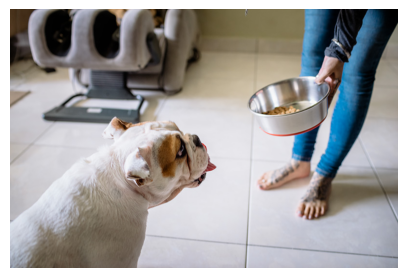

In [18]:
from PIL import Image
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

##### Cell to modify if CUDA not available

In [19]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = sam_model_path
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [20]:
masks = mask_generator.generate(image)

Show all the masks overlayed on the image

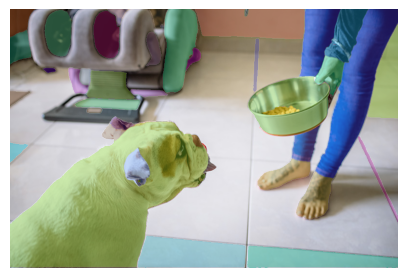

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [22]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [23]:
masks2 = mask_generator_2.generate(image)

In [24]:
len(masks2)

63

In [25]:
masks2[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

Show all the masks overlayed on the image

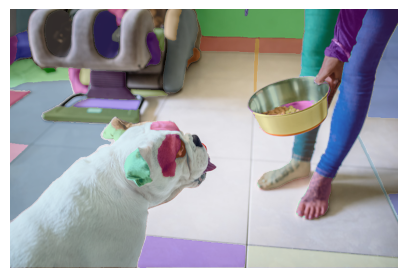

In [26]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

Show the dog mask in isolation, with dark background

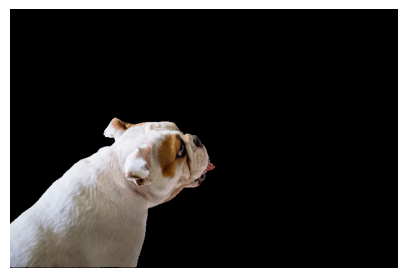

In [27]:
mask = np.where(masks2[23]['segmentation'], 1, 0)
new_image = image * np.expand_dims(mask, axis=-1)
plt.figure(figsize=(5,5))
plt.imshow(new_image)
plt.axis('off')
plt.show()

Show each mask separately

In [28]:
# for i in range(len(masks2)):
#     print(i)
#     mask = masks[i]['segmentation'].astype(np.uint8)
#     new_image = image * np.expand_dims(mask, axis=-1)
#     plt.figure(figsize=(5,5))
#     plt.imshow(new_image)
#     plt.axis('off')
#     plt.show()

Function to determine whether a mask belongs to a greater one

In [29]:
def is_part_of(mask1, mask2):
    mask1, mask2 = mask1.flatten(), mask2.flatten()
    # True if mask1 is entirely contained within mask2
    if np.any(mask1 & ~mask2):
        return False
    # True if both masks are NOT identical    
    if np.count_nonzero(mask1)==np.count_nonzero(mask2):
        return False
    return True


# Check objects belonging to mask23

for i in range(len(masks2)):
    if is_part_of(masks2[i]['segmentation'], masks2[23]['segmentation']):
        print(f"Mask {i} is part of mask23")


# Check if mask21 belongs to another mask

for i in range(len(masks2)):
    if is_part_of(masks2[21]['segmentation'], masks2[i]['segmentation']):
        print(f"Mask 21 is part of mask {i}.")

Mask 21 is part of mask23
Mask 25 is part of mask23
Mask 49 is part of mask23
Mask 21 is part of mask 23.


## Classification model

In [33]:
import timm

# To list models with a specific pattern in their name
# timm.list_models('*huge*in1k*', pretrained=True)

cv_model = timm.create_model('convnext_small.in12k_ft_in1k_384', pretrained=True).eval()
try:
    data_cfg = timm.data.resolve_data_config(cv_model.pretrained_cfg)
    transform = timm.data.create_transform(**data_cfg)
except:
    transform = Compose

AttributeError: module 'timm' has no attribute 'resolve_data_config'

Chose model blablabla because blablabla

Apply transform to image prior to inference

In [ ]:
pil_image = Image.fromarray(new_image.astype(np.uint8))
image_tensor = transform(pil_image)

Show transformed image

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(image_tensor, (1,2,0)))
plt.axis('off')
plt.show()

## Inference

In [ ]:
with torch.no_grad():
    output = cv_model(image_tensor.unsqueeze(0))
output.shape

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

In [ ]:
# Keep 3 guesses with highest probability of success
values, indices = torch.topk(probabilities, 3)
indices

Obtain labels from the `IMAGENET_1k` dataset

In [ ]:
import requests
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
print('The 3 most likely labels for the given picture are:', '\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': np.round(val.item()*100, 2)} for val, idx in zip(values, indices)]

----------------------

## Gradio app

The following cell contains the majority of the code seen in the previous sections and can be executed independently.

In [ ]:
# Setup
try:
    !pip install -qq 'git+https://github.com/facebookresearch/segment-anything.git' gradio
    !wget -qq https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
except Exception as e:
    print('Error message: ', e)
    print('Consider downloading the SAM model from:')
    print('https://github.com/facebookresearch/segment-anything#model-checkpoints')
    exit(1)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
if not torch.cuda.is_available():
    raise EnvironmentError("CUDA is not available. This code requires CUDA for adequate runtime.")
import timm
import requests
import gradio as gr
import os
import urllib.request
import warnings
warnings.simplefilter('ignore')

# Paths and settings for SAM
sam_model_path = './sam_vit_b_01ec64.pth'
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = sam_model_path
model_type = "vit_b"
device = "cuda"
# Load automatic mask generation with SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load classification model
cv_model = timm.create_model('convnext_small.in12k_ft_in1k_384', pretrained=True).eval()
try:
    data_cfg = timm.data.resolve_data_config(cv_model.pretrained_cfg)
    transform = timm.data.create_transform(**data_cfg)
except:
    transform = Compose
    
# ImageNet labels
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

# Closing active port connections
gr.close_all();

# Retains only the segmentation information for each mask
def simplify_masks(masks):
    for mask in masks:
        for i in range(6):
            mask.popitem()

def key_size(mask):
    return mask['segmentation'].sum()

# Sorts masks by size, in descending order
def sort_masks_size(masks):
    masks = sorted(masks, key=key_size, reverse=True)
    return masks

# Define constants
NUM_MASKS = 10
MIN_PROBABILITY = 0.1

def predict(image):
    try:
        # Generate masks
        masks = mask_generator.generate(image)
        # Retains only the segmentation information for each mask
        simplify_masks(masks)
        # Sorts masks by size, in descending order
        masks = sort_masks_size(masks)

        images_tensor_lst = []
        # Uses a maximum of NUM_MASKS masks / objects, the biggest ones
        for i in range(min(NUM_MASKS, len(masks))):
            mask = masks[i]['segmentation'].astype(np.uint8)
            new_image = image * np.expand_dims(mask, axis=-1)
            pil_image = Image.fromarray(new_image.astype(np.uint8))
            image_tensor = transform(pil_image).unsqueeze(0)
            images_tensor_lst.append(image_tensor)
        # Creates a tensor containing all (maximum 10) image tensors
        images_tensor = torch.cat(images_tensor_lst)
        
        # Make predictions
        with torch.no_grad():
            output = cv_model(images_tensor)
        probabilities = torch.nn.functional.softmax(output)

        # Eliminates predictions with probability of success under 10% after applying the softmax layer
        label_lst = [IMAGENET_1k_LABELS[idx].split(',')[0] 
                     for value, idx in zip(probabilities, torch.argmax(probabilities, dim=1))
                     if value>=MIN_PROBABILITY]

        return f'The given picture probably contains the following items: {set(label_lst)}'

    except Exception as e:
        return f"An error occurred: {str(e)}"
    
# Downaload example images
url1 = 'https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg'
url2 = 'https://www.closetfactory.com/wp-content/uploads/2020/01/shutterstock_1381069457.png'
os.makedirs('images', exist_ok=True)
urllib.request.urlretrieve(url1, 'images/dog1.jpg')
urllib.request.urlretrieve(url2, 'images/shutterstock.png')
examples = ['images/dog1.jpg', 'images/shutterstock.png']

# Initialize Gradio interface
gr.Interface(fn=predict, inputs='image', outputs='text', examples=examples).launch(share=True)

In [ ]:
# backlog
    # arrange transform
    # evaluacion
    # conclusion?: explain timm model selection -model size-param_count https://huggingface.co/timm/convnext_small.in12k_ft_in1k_384
    # citation for timm model and timm's r wightman
    # conclusion: Sam model, timm model, 1k classes imagenet. rubbish performance vs image to prompt models..diffusion..

## Evaluation

## Conclusion

## References

- Segment Anything Model (`SAM`) by Meta
    - https://github.com/facebookresearch/segment-anything/blob/main/README.md

    - @article{kirillov2023segany,
  title={Segment Anything},
  author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
  journal={arXiv:2304.02643},
  year={2023}
}

- Timm Library
    - https://timm.fast.ai/
    - https://huggingface.co/docs/timm/quickstart